# **Power and Energy Calculations for ASHP and IBAL**

With data from the IBAL (https://ibal.nist.gov/) and ASHP (https://github.com/ZhelunChen/HILFT-KPI-Analysis). The following code is a modified version of the MATLAB - kpi_analysis.mlx - code from the GitHub. This code provides plots of each power measurement used in calculation, then plotting the total power and energy from the total power. 

### ***For the ASHP data***
Power is in Watts (W), Energy is in Kilojoules (kJ) and they are plotted over Time in seconds (s).

*Note: timestep data was recorded every minute, so a square wave is assumed for each minute (60 s)*

### ***For the IBAL data***
Power is in Kilowatts (kW), Energy is in Kilojoules (kJ) and they are plotted over Time in seconds (s).



## **Functions**

### *result_to_df()*

A function that converts SPARQL query results to convert it into a pandas.DataFrame to easily read and access data.


### *get_time()*

Converts time obtained from the function `get_dataframe()` into seconds.


### *get_dataframe()*

Takes in variable metadata - file Location obtained from SPARQL query, dataframe - SPARQL query result after being passed to through `result_to_df()`. This grabs the time column, and seperates the measurement ids needed for the calculations into a new dataframe.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection
import rdflib

def result_to_df(qr) -> pd.DataFrame:
    for q in qr:
        print('>', q)
    d = pd.DataFrame(qr.bindings, dtype="string")
    d.columns = [str(x) for x in d.columns]
    for c in d.columns:
        d[c] = d[c].astype('str')
    return d

def get_time(time):
    h, m, s = time.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def get_dataframe(metadata, dataframe, heatpump):
    # initialize empty dataframe
    df = pd.DataFrame()

    # add time column to dataframe in seconds 
    '''
    TODO:
        - Grab time col without manual index
        - Identify how time/date time is labeled and convert to seconds without knowing how it's formatted
    '''
    if(HP == 'ASHP'):
        df.loc[:,list(dataframe.columns)[0]] = dataframe.loc[:,list(dataframe.columns)[0]].str[7:]
        for i in range(len(df)):
            df.loc[i, list(dataframe.columns)[0]] = get_time(df.loc[i, list(dataframe.columns)[0]])
    else:
        df.loc[:,list(dataframe.columns)[0]] = dataframe.loc[:,list(dataframe.columns)[0]].str[11:18]
        for i in range(len(df)):
            df.loc[i, list(dataframe.columns)[0]] = get_time(df.loc[i, list(dataframe.columns)[0]])

    for prop in metadata['colID']:
        for col in list(dataframe.columns):
            if col in prop:
                df.loc[:,col] = dataframe.loc[:,col].to_numpy()
    return df

# Define HP as HPs[0] or HPs[1] to output power and energy for ASHP/IBAL respectively
HPs = ['ASHP', 'IBAL']
HP = HPs[0]

> (rdflib.term.Literal('id_power'), rdflib.term.Literal('https://raw.githubusercontent.com/ZhelunChen/HILFT-KPI-Analysis/main/ASHP/Atlanta/Eff/Default/data.csv'))
> (rdflib.term.Literal('od_power'), rdflib.term.Literal('https://raw.githubusercontent.com/ZhelunChen/HILFT-KPI-Analysis/main/ASHP/Atlanta/Eff/Default/data.csv'))
      colID                                               file
0  id_power  https://raw.githubusercontent.com/ZhelunChen/H...
1  od_power  https://raw.githubusercontent.com/ZhelunChen/H...
     date_time  id_power  od_power
0           60        15        42
1          120        15        41
2          180        15        42
3          240        15        42
4          300        15        42
...        ...       ...       ...
1435     86160        16         0
1436     86220        16         0
1437     86280        16         0
1438     86340        16         0
1439     86400        16         0

[1440 rows x 3 columns]
id_power


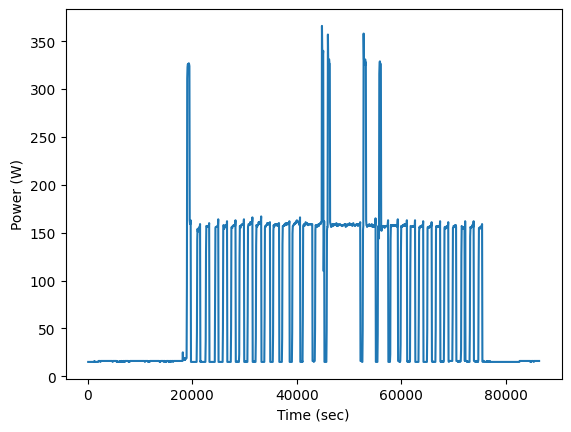

od_power


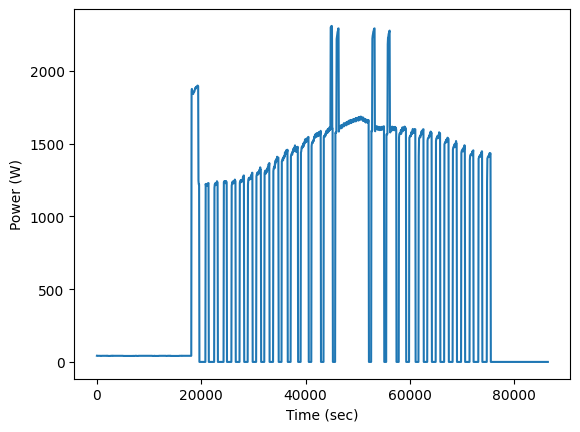

C:\Users\bje4\AppData\Local\Temp\1\ipykernel_25288\3307512461.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.42' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[row, 'energy'] = new_df.loc[row, 'power'] * 60 / 1000 # HVAC


     date_time  id_power  od_power  power  energy
0           60        15        42     57    3.42
1          120        15        41     56    3.36
2          180        15        42     57    3.42
3          240        15        42     57    3.42
4          300        15        42     57    3.42
...        ...       ...       ...    ...     ...
1435     86160        16         0     16    0.96
1436     86220        16         0     16    0.96
1437     86280        16         0     16    0.96
1438     86340        16         0     16    0.96
1439     86400        16         0     16    0.96

[1440 rows x 5 columns]


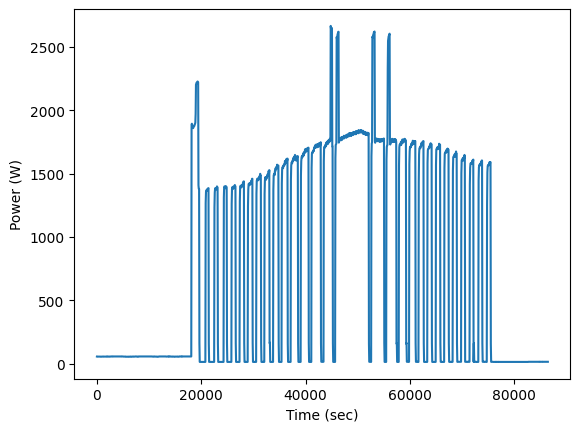

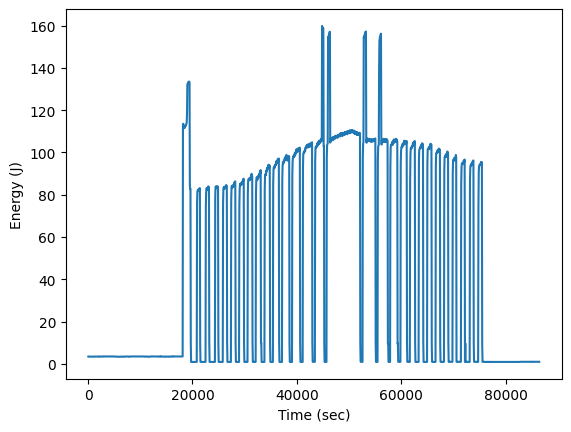

In [6]:
g = rdflib.Graph()
g.parse("https://open223.info/223p.ttl")

if(HP == 'ASHP'):
    g.parse("HPL.ttl")

    # SPARQL query - grabs measurement IDs and file/link location of the data
    query_prop = """
    PREFIX s223: <http://data.ashrae.org/standard223#>
    SELECT ?colID ?file WHERE {
        BIND(HPL:ASHP_Func AS ?ashp)
        ?ashp s223:hasInput ?input .
        ?input s223:hasExternalReference ?csvRef .
        ?csvRef a ref:csvReference .
        ?csvRef ref:csvColumnID ?colID .
        ?csvRef ref:csvFileLocation ?file .
        }
    """

    # Pass ?file (CSV) to dataframe
    query_results = result_to_df(g.query(query_prop))
    query_results = query_results.astype(str)
    print(query_results)

    # Assumes ?file is the same for all ?csvRef
    fileLocation = query_results["file"][0]
    df = pd.read_csv(fileLocation)

    new_df = get_dataframe(query_results, df, HP)
    print(new_df)
    new_df['power'] = 0
    new_df['energy'] = 0

    # Plot power for each measurement
    for col in range(len(new_df.columns) - 2):
        if col + 1 == len(new_df.columns) - 2:
            break
        else:
            print(new_df.columns.values.tolist()[col + 1])
            plt.plot(new_df['date_time'], new_df[new_df.columns.values.tolist()[col + 1]])
            plt.xlabel("Time (sec)")
            plt.ylabel("Power (W)")
            plt.show()

    # Calculate power and energy
    for row in range(len(new_df.index)):
        for col in range(len(new_df.columns) - 2):
            if col + 1 == len(new_df.columns) - 2:
                break
            else:
                new_df.loc[row, 'power'] = new_df.iloc[row]['power'] + new_df.iloc[row,col + 1]
        new_df.loc[row, 'energy'] = new_df.loc[row, 'power'] * 60 / 1000 # HVAC

    print(new_df)

    plt.plot(new_df['date_time'], new_df['power'])
    plt.xlabel("Time (sec)")
    plt.ylabel("Power (W)")
    plt.show()

    plt.plot(new_df['date_time'], new_df['energy'])
    plt.xlabel("Time (sec)")
    plt.ylabel("Energy (kJ)")
    plt.show()

# HP == 'IBAL'
else:
    g.parse("IBAL.ttl")

    query_prop = """
    PREFIX s223: <http://data.ashrae.org/standard223#>
    SELECT ?colID ?file WHERE {
        BIND(IBAL:IBAL_Func AS ?ibal)
        ?ibal s223:hasInput ?input .
        ?input s223:hasExternalReference ?csvRef .
        ?csvRef a ref:csvReference .
        ?csvRef ref:csvColumnID ?colID .
        ?csvRef ref:csvFileLocation ?file .
        }
    """

    # Pass ?file (CSV) to dataframe

    query_results = result_to_df(g.query(query_prop))
    query_results = query_results.astype(str)
    print(query_results)

    # Assumes ?file is the same for all ?csvRef
    fileLocation = query_results["file"][0]
    df = pd.read_csv(fileLocation)

    new_df = get_dataframe(query_results, df, HP)
    print(new_df)
    new_df['power'] = 0
    new_df['energy'] = 0

    # Plot power for each measurement
    for col in range(len(new_df.columns) - 2):
        if col + 1 == len(new_df.columns) - 2:
            break
        else:
            print(new_df.columns.values.tolist()[col + 1])
            plt.plot(new_df['time'], new_df[new_df.columns.values.tolist()[col + 1]])
            plt.xlabel("Time (sec)")
            plt.ylabel("Power (kW)")
            plt.show()

    # Calculate power and energy
    for row in range(len(new_df.index)):
        for col in range(len(new_df.columns)):
            if col + 1 == len(new_df.columns) - 2:
                break
            else:
                new_df.loc[row, 'power'] = new_df.iloc[row]['power'] + new_df.iloc[row,col + 1]
        new_df.loc[row, 'energy'] = new_df.loc[row, 'power'] * 10 # HVAC

    print(new_df)

    plt.plot(new_df['time'], new_df['power'])
    plt.xlabel("Time (sec)")
    plt.ylabel("Power (kW)")
    plt.show()

    plt.plot(new_df['time'], new_df['energy'])
    plt.xlabel("Time (sec)")
    plt.ylabel("Energy (kJ)")
    plt.show()